# <center/>应用自动数据增强

## 概述

自动数据增强（AutoAugment）是在一系列图像增强子策略的搜索空间中，通过搜索算法找到适合特定数据集的图像增强方案。MindSpore的`c_transforms`模块提供了丰富的C++算子来实现AutoAugment，用户也可以自定义函数或者算子来实现。更多MindSpore算子的详细说明参见[API文档](https://www.mindspore.cn/doc/api_python/zh-CN/r1.1/mindspore/mindspore.dataset.vision.html)。

MindSpore算子和AutoAugment中的算子的对应关系如下：

| AutoAugment算子 | MindSpore算子 | 描述 |
| :------: | :------ | ------ |
| shearX | RandomAffine | 横向剪切 |
| shearY | RandomAffine | 纵向剪切 |
| translateX | RandomAffine | 水平平移 |
| translateY | RandomAffine | 垂直平移 |
| rotate | RandomRotation | 旋转变换 |
| color | RandomColor | 颜色变换 |
| posterize | RandomPosterize | 减少颜色通道位数 |
| solarize | RandomSolarize | 指定的阈值范围内，反转所有的像素点 |
| contrast | RandomColorAdjust | 调整对比度 |
| sharpness | RandomSharpness | 调整锐度 |
| brightness | RandomColorAdjust | 调整亮度 |
| autocontrast | AutoContrast | 最大化图像对比度 |
| equalize | Equalize | 均衡图像直方图 |
| invert | Invert | 反转图像 |



> 本文档适用于CPU、GPU和Ascend环境。

## 整体流程
- 准备环节。
- CIFAR-10自动数据增强。

## 准备环节

### 下载所需数据集

运行以下命令来获取数据集：

In [1]:
! wget -N https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar10.zip
! unzip -o cifar10.zip -d ./datasets
! tree ./datasets/cifar10

--2020-12-09 11:25:17--  https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar10.zip
Resolving proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)... 192.168.0.172
Connecting to proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)|192.168.0.172|:8083... connected.
Proxy request sent, awaiting response... 200 OK
Length: 166235630 (159M) [application/zip]
Saving to: ‘cifar10.zip’

cifar10.zip         100%[===================>] 158.53M  47.1MB/s    in 3.4s    

2020-12-09 11:25:21 (47.1 MB/s) - ‘cifar10.zip’ saved [166235630/166235630]

Archive:  cifar10.zip
   creating: ./datasets/cifar10/
   creating: ./datasets/cifar10/test/
  inflating: ./datasets/cifar10/test/test_batch.bin  
   creating: ./datasets/cifar10/train/
  inflating: ./datasets/cifar10/train/batches.meta.txt  
  inflating: ./datasets/cifar10/train/data_batch_1.bin  
  inflating: ./datasets/cifar10/train/data_batch_2.bin  
  inflating: ./data

## CIFAR-10自动数据增强

本教程以在CIFAR-10数据集上实现AutoAugment作为示例。

针对CIFAR-10数据集的数据增强策略包含25条子策略，每条子策略中包含两种变换，针对一个batch中的每张图像随机挑选一个子策略的组合，以预定的概率来决定是否执行子策略中的每种变换。

用户可以使用MindSpore中`c_transforms`模块的`RandomSelectSubpolicy`接口来实现AutoAugment，在CIFAR-10分类训练中标准的数据增强方式分以下几个步骤：

- `RandomCrop`：随机裁剪。

- `RandomHorizontalFlip`：水平方向上随机翻转。

- `Normalize`：归一化。

- `HWC2CHW`：图片通道变化。

在`RandomCrop`后插入AutoAugment变换，如下所示：

1. 引入MindSpore数据增强模块。

In [2]:
from mindspore import dtype as mstype
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as c_vision
import mindspore.dataset.transforms.c_transforms as c_transforms
import matplotlib.pyplot as plt

2. 定义MindSpore算子到AutoAugment算子的映射：

In [3]:
# define Auto Augmentation operators
PARAMETER_MAX = 10

def float_parameter(level, maxval):
    return float(level) * maxval /  PARAMETER_MAX

def int_parameter(level, maxval):
    return int(level * maxval / PARAMETER_MAX)

def shear_x(level):
    v = float_parameter(level, 0.3)
    return c_transforms.RandomChoice([c_vision.RandomAffine(degrees=0, shear=(-v,-v)), c_vision.RandomAffine(degrees=0, shear=(v, v))])

def shear_y(level):
    v = float_parameter(level, 0.3)
    return c_transforms.RandomChoice([c_vision.RandomAffine(degrees=0, shear=(0, 0, -v,-v)), c_vision.RandomAffine(degrees=0, shear=(0, 0, v, v))])

def translate_x(level):
    v = float_parameter(level, 150 / 331)
    return c_transforms.RandomChoice([c_vision.RandomAffine(degrees=0, translate=(-v,-v)), c_vision.RandomAffine(degrees=0, translate=(v, v))])

def translate_y(level):
    v = float_parameter(level, 150 / 331)
    return c_transforms.RandomChoice([c_vision.RandomAffine(degrees=0, translate=(0, 0, -v,-v)), c_vision.RandomAffine(degrees=0, translate=(0, 0, v, v))])

def color_impl(level):
    v = float_parameter(level, 1.8) + 0.1
    return c_vision.RandomColor(degrees=(v, v))

def rotate_impl(level):
    v = int_parameter(level, 30)
    return c_transforms.RandomChoice([c_vision.RandomRotation(degrees=(-v, -v)), c_vision.RandomRotation(degrees=(v, v))])

def solarize_impl(level):
    level = int_parameter(level, 256)
    v = 256 - level
    return c_vision.RandomSolarize(threshold=(0, v))

def posterize_impl(level):
    level = int_parameter(level, 4)
    v = 4 - level
    return c_vision.RandomPosterize(bits=(v, v))

def contrast_impl(level):
    v = float_parameter(level, 1.8) + 0.1
    return c_vision.RandomColorAdjust(contrast=(v, v))

def autocontrast_impl(level):
    return c_vision.AutoContrast()

def sharpness_impl(level):
    v = float_parameter(level, 1.8) + 0.1
    return c_vision.RandomSharpness(degrees=(v, v))

def brightness_impl(level):
    v = float_parameter(level, 1.8) + 0.1
    return c_vision.RandomColorAdjust(brightness=(v, v))

3. 定义CIFAR-10数据集的AutoAugment策略：

- 预置一条简单的子策略，其中只包含`RandomRotation`和`RandomColor`两个操作，概率分别为1.0和0.0。

In [4]:
policy_list = [
    [(c_vision.RandomRotation((90, 90)), 1.0), (c_vision.RandomColorAdjust(), 0.0)]
]

- 预置多个子策略。

In [5]:
 # define the Auto Augmentation policy
cifar10_policy = [
    [(posterize_impl(8), 0.4), (rotate_impl(9), 0.6)],
    [(solarize_impl(5), 0.6), (autocontrast_impl(5), 0.6)],
    [(c_vision.Equalize(), 0.8), (c_vision.Equalize(), 0.6)],
    [(posterize_impl(7), 0.6), (posterize_impl(6), 0.6)],
    [(c_vision.Equalize(), 0.4), (solarize_impl(4), 0.2)],

    [(c_vision.Equalize(), 0.4), (rotate_impl(8), 0.8)],
    [(solarize_impl(3), 0.6), (c_vision.Equalize(), 0.6)],
    [(posterize_impl(5), 0.8), (c_vision.Equalize(), 1.0)],
    [(rotate_impl(3), 0.2), (solarize_impl(8), 0.6)],
    [(c_vision.Equalize(), 0.6), (posterize_impl(6), 0.4)],

    [(rotate_impl(8), 0.8), (color_impl(0), 0.4)],
    [(rotate_impl(9), 0.4), (c_vision.Equalize(), 0.6)],
    [(c_vision.Equalize(), 0.0), (c_vision.Equalize(), 0.8)],
    [(c_vision.Invert(), 0.6), (c_vision.Equalize(), 1.0)],
    [(color_impl(4), 0.6), (contrast_impl(8), 1.0)],

    [(rotate_impl(8), 0.8), (color_impl(2), 1.0)],
    [(color_impl(8), 0.8), (solarize_impl(7), 0.8)],
    [(sharpness_impl(7), 0.4), (c_vision.Invert(), 0.6)],
    [(shear_x(5), 0.6), (c_vision.Equalize(), 1.0)],
    [(color_impl(0), 0.4), (c_vision.Equalize(), 0.6)],

    [(c_vision.Equalize(), 0.4), (solarize_impl(4), 0.2)],
    [(solarize_impl(5), 0.6), (autocontrast_impl(5), 0.6)],
    [(c_vision.Invert(), 0.6), (c_vision.Equalize(), 1.0)],
    [(color_impl(4), 0.6), (contrast_impl(8), 1.0)],
    [(c_vision.Equalize(), 0.8), (c_vision.Equalize(), 0.6)],
]

4. 在`RandomCrop`操作后插入AutoAugment变换。

In [6]:
def create_dataset(dataset_path, do_train, policy,repeat_num=1, batch_size=32, shuffle=True, num_samples=5):
    # create a train dataset for ResNet-50
    data = ds.Cifar10Dataset(dataset_path, num_parallel_workers=8,
                               shuffle=shuffle, num_samples=num_samples)

    image_size = 224
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]

    # define map operations
    if do_train:
        trans = [
            c_vision.RandomCrop((32,32),(4,4,4,4)),
        ]

        post_trans = [
            c_vision.RandomHorizontalFlip(prob=0.5),
        ]
    else:
        trans = [
            c_vision.Decode(),
            c_vision.Resize(256),
            c_vision.CenterCrop(image_size),
            c_vision.Normalize(mean=mean, std=std),
            c_vision.HWC2CHW()
        ]
    data = data.map(operations=trans, input_columns="image")
    if do_train:
        data = data.map(operations=c_vision.RandomSelectSubpolicy(policy), input_columns=["image"])
        data = data.map(operations=post_trans, input_columns="image")
    type_cast_op = c_transforms.TypeCast(mstype.int32)
    data = data.map(operations=type_cast_op, input_columns="label")
    # apply the batch operation
    data = data.batch(batch_size, drop_remainder=True)
    # apply the repeat operation
    data = data.repeat(repeat_num)
    return data

5. 验证自动数据增强效果。

- 在一条子策略的情况下，因为`RandomRotation`操作的概率设置为1，也就是该操作肯定会发生，而`RandomColor`操作的概率设置为0，也就是该操作不会发生。

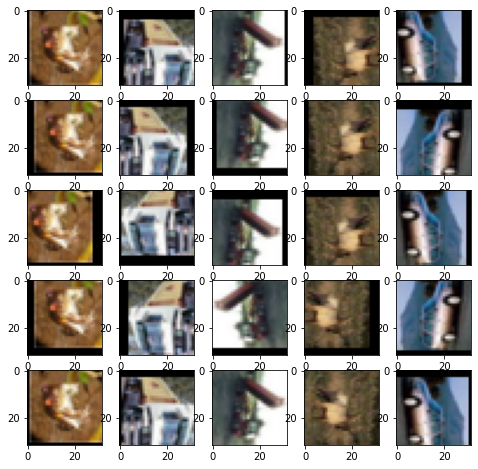

In [7]:
DATA_DIR = "./datasets/cifar10/train"
data = create_dataset(dataset_path=DATA_DIR, do_train=True, batch_size=5, shuffle=False, num_samples=5, policy=policy_list)

epochs = 5
itr = data.create_dict_iterator()
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
step_num = 0
for ep_num in range(epochs):
    for data in itr:
        step_num += 1
        for index in range(rows):
            fig.add_subplot(rows, columns, ep_num * rows + index + 1)
            plt.imshow(data['image'].asnumpy()[index])
plt.show()

- 在多个子策略的情况下，每张图片首先等概率的随机选取一条子策略，然后根据该子策略内俩个操作的概率情况，进行随机的自动数据增强，增强数据的泛化性。

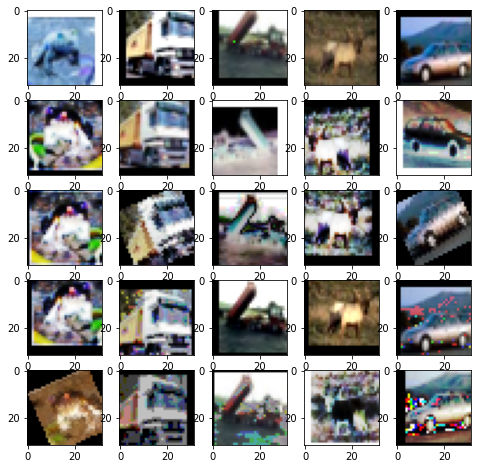

In [8]:
DATA_DIR = "./datasets/cifar10/train"
data = create_dataset(dataset_path=DATA_DIR, do_train=True, batch_size=5, shuffle=False, num_samples=5, policy=cifar10_policy)

epochs = 5
itr = data.create_dict_iterator()
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
step_num = 0
for ep_num in range(epochs):
    for data in itr:
        step_num += 1
        for index in range(rows):
            fig.add_subplot(rows, columns, ep_num * rows + index + 1)
            plt.imshow(data['image'].asnumpy()[index])
plt.show()

 > 为了更好地演示效果，此处只加载5张图片，且读取时不进行`shuffle`操作，自动数据增强时也不进行`Normalize`和`HWC2CHW`操作。
 运行结果可以看到，batch中每张图像的增强效果，水平方向表示1个batch的5张图像，垂直方向表示5个batch。